In [3]:
import numpy as np
import pandas as pd
#from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

%matplotlib inline
import matplotlib.pyplot as plt


# load the training features and "labels"
dengue_features_train = pd.read_csv("dengue_features_train.csv", index_col=[0,1,2])
dengue_labels_train = pd.read_csv("dengue_labels_train.csv", index_col=[0,1,2])
dengue_features_train.drop('week_start_date', axis=1, inplace=True)


I will start by looking at some basic descriptive statistics for the various features to see if there may be a need for preprocessing before I start looking for patterns in the data.
Beware of NaN's

In [4]:
def basic_data_stats(data):
    nrows = data.shape[0]
    ncols = data.shape[1]
    print "basic stats:"
    print "nrows / ncols = ", nrows, ncols    
    non_null_count = data.count(axis=0)
#    print non_null_count.head(10)
    means = data.mean(axis=0)
#    print means.head(10)
    
    descriptive = pd.DataFrame({'mean': data.mean(), 'sd': data.std(), 'missing': data.count() - nrows})
    print descriptive.head(10)
    print "end basic stats"

#   feature_label_corrs(data, labels) 
#   data : a DataFrame containing numeric feature data
#   labels: a Series containing the labels/outputs to find correlations against
def feature_label_corrs(data, labels, max_shift):
    ncols = data.shape[1]
    print "corrs data shape : ", data.shape
    print "corrs labels shape : ", labels.shape

    # create a new DataFrame to put the correlations in
    corr_vs_time_shift = pd.DataFrame(np.zeros((max_shift+1,ncols)), columns=data.columns)
    labels_shifted = labels.copy()
    for shift in range(0,max_shift+1):
        for feature in data.columns:
            feature_data = data[feature]
            correl = feature_data.corr(labels_shifted)
            if np.isnan(correl): 
                print "correl[", feature, "] at shift ", shift, " is nan"
                print "shifted: ", labels_shifted
            corr_vs_time_shift[feature][shift] = correl
            # shift the "labels" or outputs to earlier time, to see how they correlate to past features            
        for i in range(1, labels_shifted.shape[0]-1):
            labels_shifted.iloc[i-1] = labels_shifted.iloc[i]
        labels_shifted[-1] = 0
            
    # print corr_vs_time_shift.head()
    plt.figure(figsize=(14,6))
    for feature in data.columns:
        plt.plot(corr_vs_time_shift[feature], label=feature)    
    plt.legend()
    plt.show()
    
    return corr_vs_time_shift


def feature_feature_corrs(data, thresh = 0.8):
    ncols = data.shape[1]
    feature_corrs = data.corr()
    for i in range(0, ncols):
        for j in range(0, i):
            if feature_corrs.iloc[i,j] > thresh:
                print feature_corrs.columns[i], " <=> ", feature_corrs.columns[j], " : ", feature_corrs.iloc[i,j]
    
    return feature_corrs

def examine_mutual_info(features, labels):
    mi = mutual_info_regression(features, labels['total_cases'])
    for i in range(0, len(mi)):
        print features.columns[i], " : mi = ", mi[i]
    print "mi = :\n", mi



In [5]:

def select_best_features(feature_data, corr_vs_time_shift, num_features, do_shift=False):
    shifts = []
    for feature in corr_vs_time_shift.columns:
        max_corr_idx = corr_vs_time_shift[feature].idxmax()
        max_corr = corr_vs_time_shift[feature].iloc[max_corr_idx]
        shifts.append((feature, max_corr, max_corr_idx))
        
    shifts.sort(key=lambda m: abs(m[1]), reverse=True)
    del shifts[num_features:]
    best_features = feature_data[[shift[0] for shift in shifts]]
    if do_shift:
        nrows = best_features.shape[0]
        print "select best features - nrows = ", nrows

        for shift_tup in shifts:
            feature = shift_tup[0]
            shift = shift_tup[2]
            for row in range(nrows-1, shift-1, -1):
#            print "row, row-shift: ", row,row-shift
                best_features.iloc[row].loc[feature] = best_features.iloc[row-shift].loc[feature]
               
            for row in range(0, shift):
                best_features.iloc[row].loc[feature] = best_features.iloc[shift].loc[feature]

    return best_features       

def create_timeshifted_features(feature_data, history_depth):
    for feature in feature_data.columns:
        data_col = feature_data[feature].values
        first_val = data_col[0]
        for i in range(1, history_depth+1):
            data_col = np.insert(data_col, 0, first_val)
            data_col = np.delete(data_col, -1)
        new_feat_name = feature + "_" + str(i) + "weeksago"
        feature_data[new_feat_name] = data_col

def create_rolling_avg_features(feature_data, window_depth):
    for feature in feature_data.columns:
        rolling_mean_data = feature_data[feature].rolling(min_periods=1,window=window_depth,center=False).mean()
        new_feat_name = feature + "_" + str(window_depth) + "week_mean"
        feature_data[new_feat_name] = rolling_mean_data
            
            
def de_seasonalize(labels):
    # find mean value in each "week of year"
    weekly_means = labels.groupby(level='weekofyear').mean()

    # copy the labels dataframe
    labels_seasonal = labels.copy()
    for i in range(0, labels.shape[0]):
        woy = (labels.index[i][1])
        labels_seasonal['total_cases'].iloc[i] = weekly_means['total_cases'][woy]
    de_seasonalized = labels.sub(labels_seasonal)

    return de_seasonalized, labels_seasonal

def preproc_features(features):
    # start by doing simple interpolation for missing data
    features_interp = features.interpolate()

    # create additional features
    create_rolling_avg_features(features_interp, 12)
    
    return features_interp
    
def find_best_features(features, labels):
    nrows = features.shape[0]
    train_split = int((nrows*80)/100)
    feat_train_set = features.head(train_split)
    feat_val_set = features.tail(nrows-train_split)

    labels_train_set = labels['total_cases'].head(train_split)
    labels_val_set = labels['total_cases'].tail(nrows-train_split)

    print "features shape: ", features.shape
    print "train split: ", train_split

    xtree_model = ExtraTreesRegressor(n_estimators=6, criterion="mae", max_depth=6, random_state=0)

    regressor = xtree_model
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    feat_elim = RFECV(regressor, step=1, cv=10, scoring=scorer, verbose=0, n_jobs=1)
    feat_elim.fit(features, labels['total_cases'])
    print "optimal feature selection : ", feat_elim.support_
    print features.columns[feat_elim.support_]
    return feat_elim.support_

def smooth_predictions(predicted_values):
    pred_series = pd.Series(predicted_values)
    smoothed = pred_series.rolling(min_periods=1,window=3,center=False).mean()
    return smoothed.values
    

def fit_regression(features, labels):
    nrows = features.shape[0]
    train_split = int((nrows*80)/100)
    feat_train_set = features.head(train_split)
    feat_val_set = features.tail(nrows-train_split)

    labels_train_set = labels['total_cases'].head(train_split)
    labels_val_set = labels['total_cases'].tail(nrows-train_split)

    print "features shape: ", features.shape
    print "train split: ", train_split

    # do a simple regression fit
#    regressor = LinearRegression()
#    regressor = RandomForestRegressor(n_estimators=3, criterion="mse", max_depth=4, random_state=0)
    xtree_model = ExtraTreesRegressor(n_estimators=6, criterion="mae", max_depth=6, random_state=0)
    svr_model = SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=200.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)

    regressor = BaggingRegressor(xtree_model, n_estimators=50, max_samples=0.6, max_features=0.5,
                           bootstrap=True , bootstrap_features=True, oob_score=True, random_state=0)

#    regressor = svr_model
    regressor.fit(feat_train_set, labels_train_set)

    mean_cases = labels_train_set.mean()
    print "mean cases = ", mean_cases
#    predicted_values = np.ones((nrows))
#   predicted_values *= mean_cases
#   print "mae against mean cases, for all data: ", mean_absolute_error(labels['total_cases'], predicted_values)
    
    predicted_values = regressor.predict(feat_val_set)
#    np.clip(predicted_values, 0, 999999, out=predicted_values)
    np.rint(predicted_values, predicted_values)
    
    print "mae for test set: ", mean_absolute_error(labels_val_set, predicted_values)

    predicted_values = regressor.predict(features)
#    np.clip(predicted_values, 0, 999999, out=predicted_values)
    np.rint(predicted_values, predicted_values)

    print "mae for full data: ", mean_absolute_error(labels['total_cases'], predicted_values)
    week = range(0, nrows)
    plt.figure(figsize=(14,6))
    plt.plot(week, predicted_values, 'r--', week, labels['total_cases'], 'b--')
    fig = plt.gcf()
    fig.set_size_inches(12,6,forward=True)
    plt.show()

    return regressor

    
#keep_features = ['ndvi_sw', 'reanalysis_avg_temp_k', 'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k',
#                'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm']



corrs data shape :  (936, 20)
corrs labels shape :  (936L,)


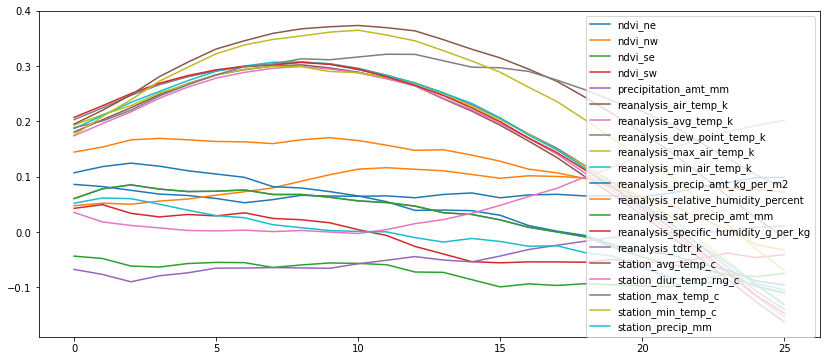

ndvi_sw  <=>  ndvi_se  :  0.814621467302
reanalysis_avg_temp_k  <=>  reanalysis_air_temp_k  :  0.997507006022
reanalysis_dew_point_temp_k  <=>  reanalysis_air_temp_k  :  0.903481091348
reanalysis_dew_point_temp_k  <=>  reanalysis_avg_temp_k  :  0.895372696029
reanalysis_max_air_temp_k  <=>  reanalysis_air_temp_k  :  0.935339397203
reanalysis_max_air_temp_k  <=>  reanalysis_avg_temp_k  :  0.93920169559
reanalysis_max_air_temp_k  <=>  reanalysis_dew_point_temp_k  :  0.847654427368
reanalysis_min_air_temp_k  <=>  reanalysis_air_temp_k  :  0.942248412472
reanalysis_min_air_temp_k  <=>  reanalysis_avg_temp_k  :  0.939127158959
reanalysis_min_air_temp_k  <=>  reanalysis_dew_point_temp_k  :  0.899007837608
reanalysis_min_air_temp_k  <=>  reanalysis_max_air_temp_k  :  0.828665104633
reanalysis_sat_precip_amt_mm  <=>  precipitation_amt_mm  :  1.0
reanalysis_specific_humidity_g_per_kg  <=>  reanalysis_air_temp_k  :  0.905003622676
reanalysis_specific_humidity_g_per_kg  <=>  reanalysis_avg_temp_k

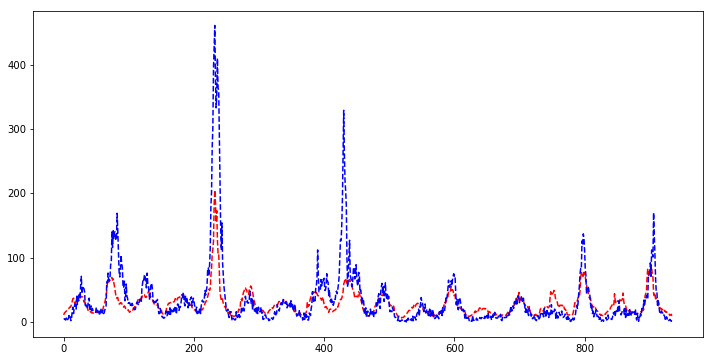

In [6]:
sj_features_train = dengue_features_train.loc['sj'].interpolate()
sj_labels_train = dengue_labels_train.loc['sj']

# de-seasonalize !!!
#sj_labels_train, seasonal = de_seasonalize(sj_labels_train)
#print "mae for seasonal only: ", mean_absolute_error(dengue_labels_train.loc['sj']['total_cases'], seasonal['total_cases'])

corr_vs_time_shift = feature_label_corrs(sj_features_train, sj_labels_train['total_cases'], 25)
feature_feature_corrs(sj_features_train)
create_rolling_avg_features(sj_features_train, 12)
#create_timeshifted_features(sj_features_train, 16)

#sj_optimal_feature_selection = find_best_features(sj_features_train, sj_labels_train)
# This is a pre-calculated optimal feature selection
sj_optimal_feature_selection = [False, False, False, False, False, False, False, False, False, False,
                                False, False, False, False, False, False, False, False, False, False,
                                False,  True, False, True, False, False, False,  True, False, False,
                                True, True, False, False,  True,  True, False,  True,  True, False]

features = sj_features_train.loc[:, sj_optimal_feature_selection]
sj_regressor = fit_regression(features, sj_labels_train)


corrs data shape :  (520, 20)
corrs labels shape :  (520L,)


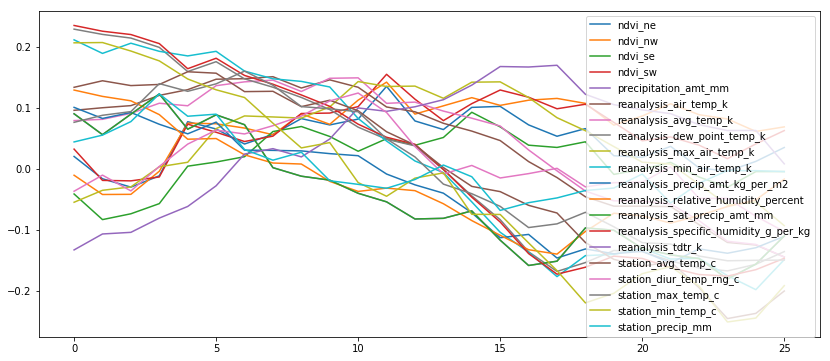

ndvi_sw  <=>  ndvi_ne  :  0.842922036567
reanalysis_avg_temp_k  <=>  reanalysis_air_temp_k  :  0.973333733162
reanalysis_sat_precip_amt_mm  <=>  precipitation_amt_mm  :  1.0
reanalysis_specific_humidity_g_per_kg  <=>  reanalysis_dew_point_temp_k  :  0.997776973353
reanalysis_tdtr_k  <=>  reanalysis_max_air_temp_k  :  0.800358748326
features shape:  (520, 9)
train split:  416
mean cases =  7.07692307692
mae for test set:  6.54807692308
mae for full data:  4.72692307692


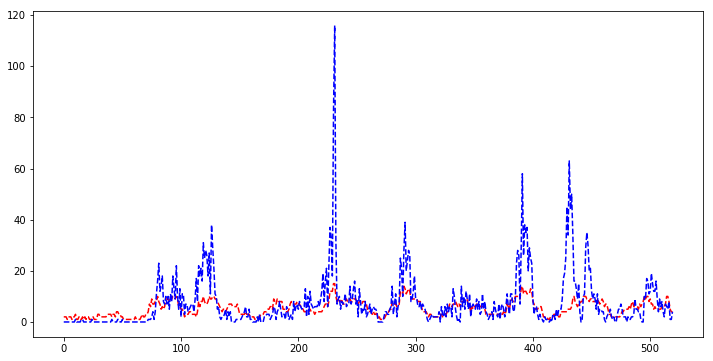

In [7]:
iq_features_train = dengue_features_train.loc['iq'].interpolate()
iq_labels_train = dengue_labels_train.loc['iq']

# de-seasonalize !!!
#sj_labels_train, seasonal = de_seasonalize(sj_labels_train)
#print "mae for seasonal only: ", mean_absolute_error(dengue_labels_train.loc['sj']['total_cases'], seasonal['total_cases'])

corr_vs_time_shift = feature_label_corrs(iq_features_train, iq_labels_train['total_cases'], 25)
feature_feature_corrs(iq_features_train)
create_rolling_avg_features(iq_features_train, 6)
#create_timeshifted_features(iq_features_train, 16)

#iq_optimal_feature_selection = find_best_features(iq_features_train, iq_labels_train)
# This is a pre-calculated optimal feature selection
iq_optimal_feature_selection = [False, False, False, False, False, False, False, False, False,
                                False, False, False, False, False, False, False, False, False,
                                False, False, False, False, False, False, False, False,  True,
                                True,  True,  True, False, False, False,  True,  True,  True,
                                True, False, False,  True]
features = iq_features_train.loc[:, iq_optimal_feature_selection]
iq_regressor = fit_regression(features, iq_labels_train)


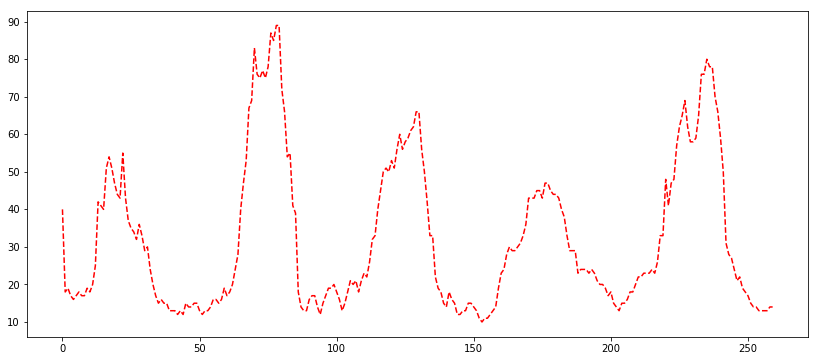

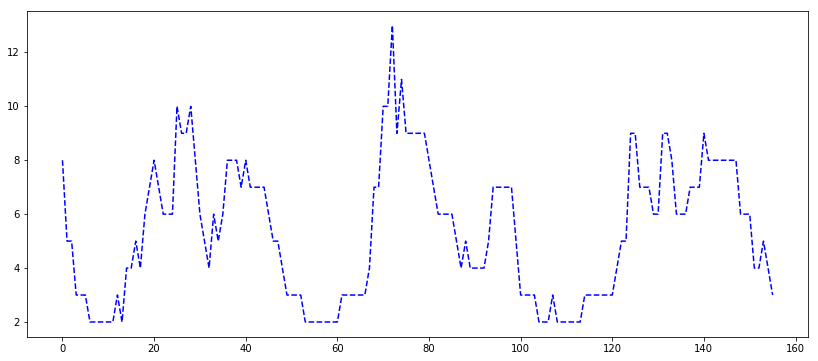

In [9]:
dengue_features_test = pd.read_csv("dengue_features_test.csv", index_col=[0,1,2])
dengue_features_test.drop('week_start_date', axis=1, inplace=True)

sj_features_test = dengue_features_test.loc['sj'].interpolate()
create_rolling_avg_features(sj_features_test, 12)
sj_features_test = sj_features_test.loc[:, sj_optimal_feature_selection]
sj_predicted_values = sj_regressor.predict(sj_features_test)
np.rint(sj_predicted_values, sj_predicted_values)
sj_predicted_values = np.int64(sj_predicted_values)

iq_features_test = dengue_features_test.loc['iq'].interpolate()
create_rolling_avg_features(iq_features_test, 6)
iq_features_test = iq_features_test.loc[:, iq_optimal_feature_selection]
iq_predicted_values = iq_regressor.predict(iq_features_test)
np.rint(iq_predicted_values, iq_predicted_values)
iq_predicted_values = np.int64(iq_predicted_values)

submission = pd.read_csv("submission_format.csv", index_col=[0, 1, 2])
submission.total_cases = np.concatenate([sj_predicted_values, iq_predicted_values])
submission.to_csv("dengue_predictions_2.csv")


nrows = len(sj_predicted_values)
week = range(0, nrows)
plt.figure(figsize=(14,6))
plt.plot(week, sj_predicted_values, 'r--')
#fig = plt.gcf()
#fig.set_size_inches(12,6,forward=True)
plt.show()

nrows = len(iq_predicted_values)
week = range(0, nrows)
plt.figure(figsize=(14,6))
plt.plot(week, iq_predicted_values, 'b--')
#fig = plt.gcf()
#fig.set_size_inchesiq2,6,forward=True)
plt.show()


